In [ ]:
# %pip install -U matplotlib
# %pip install SimpleITK
# %pip install ipywidgets
# %pip install opencv-python
# %pip install antspyx
# %pip install tf-keras
# %pip install --upgrade tensorflow-probability
# %pip install antspynet
# %pip install templateflow
# %pip install seaborn

In [1]:
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


In [2]:
#https://ida.loni.usc.edu/pages/access/studyData.jsp?categoryId=2&subCategoryId=55
df = pd.read_csv('Participant_Status_22Mar2024.csv')
df.head()

,PATNO,COHORT,COHORT_DEFINITION,ENROLL_DATE,ENROLL_STATUS,STATUS_DATE,ENROLL_AGE,INEXPAGE,AV133STDY,TAUSTDY,...,COMMENTS,CONDATE,ENRLPINK1,ENRLPRKN,ENRLSRDC,ENRLHPSM,ENRLRBD,ENRLLRRK2,ENRLSNCA,ENRLGBA
0,3000,2,Healthy Control,02/2011,Enrolled,05/2021,69.1,INEXHC,0.0,0.0,...,NaN,10/2023,0.0,0.0,0.0,0,0,0,0,0
1,3001,1,Parkinson's Disease,03/2011,Enrolled,09/2021,65.1,INEXPD,0.0,0.0,...,NaN,10/2023,0.0,0.0,1.0,0,0,0,0,0
2,3002,1,Parkinson's Disease,03/2011,Enrolled,09/2021,67.6,INEXPD,0.0,0.0,...,NaN,10/2023,0.0,0.0,1.0,0,0,0,0,0
3,3003,1,Parkinson's Disease,04/2011,Enrolled,01/2022,56.7,INEXPD,0.0,0.0,...,NaN,10/2023,0.0,0.0,1.0,0,0,0,0,0
4,3004,2,Healthy Control,04/2011,Enrolled,01/2022,59.4,INEXHC,0.0,0.0,...,NaN,10/2023,0.0,0.0,0.0,0,0,0,0,0


In [ ]:
df.columns

In [ ]:
# df = df[condition]
df["COHORT"].value_counts()

In [ ]:
df["ENROLL_STATUS"].value_counts()

In [ ]:
condition = df["ENROLL_STATUS"].isin(["Complete", "Withdrew", "Enrolled", "Baseline"])
df[condition]["COHORT"].value_counts()
#her

In [ ]:
condition = df["ENROLL_STATUS"].isin(["Enrolled"])
df[condition]["COHORT"].value_counts()

In [ ]:
condition = df["ENROLL_STATUS"].isin(["Complete", "Withdrew"])
df[condition]["COHORT"].value_counts()

In [ ]:
condition = df["ENROLL_STATUS"].isin(["Complete", "Withdrew", "Baseline"])
df[condition]["COHORT"].value_counts()

In [ ]:
img = np.asarray(Image.open('status.png'))
plt.imshow(img)

In [ ]:
df.columns

In [ ]:
df["ENROLL_STATUS"].value_counts()

In [ ]:
condition = df["ENROLL_STATUS"].isin(["Complete", "Withdrew"])
sample_1 = df[(df["COHORT"] == 1) & condition]
sample_2 = df[(df["COHORT"] == 2) & condition]
sample_3 = df[(df["COHORT"] == 3) & condition]
sample_4 = df[(df["COHORT"] == 4) & condition]

df2 = pd.concat([sample_1, sample_2, sample_3, sample_4])
df2["COHORT"].value_counts()

In [ ]:
img = np.asarray(Image.open('cohort.png'))
plt.imshow(img)

In [ ]:
#89 at least 2 visits
#204 any date
import os
import shutil

coherts = {}
df4 = df[df["ENROLL_STATUS"].isin(["Complete", "Withdrew"])]
total = 0
total_to_remove = 0
for p in os.listdir('PPMI'):
    try:
        patno = int(p)
    except ValueError:
        print("error", p) 
        continue

    matching_rows = df4[df4["PATNO"] == patno]
    if not matching_rows.empty:
        total += 1
        coherts[patno] = matching_rows["COHORT"].values[0]
    else:
        path_to_remove = os.path.join("PPMI", str(patno))
        shutil.rmtree(path_to_remove)
        # print("removed", patno)
        total_to_remove +=1

# for c in range(1, 5):
#     print(f"COHORT {c}: {len([k for k, v in coherts.items() if v == c])}")

total

In [ ]:
total_to_remove

In [ ]:
# export TEMPLATEFLOW_HOME="C:/Users/andre/parkinson/templates"

In [ ]:
import os
import SimpleITK as sitk
from antspynet.utilities import brain_extraction
from templateflow import api as tflow
import ants

template = tflow.get('MNI152Lin', desc=None, resolution=1, suffix='T2w', extension='nii.gz')
mni_template_path = str(template)
mni_nifti = ants.image_read(mni_template_path)

template_brain = brain_extraction(mni_nifti, modality="t2", verbose=False)

template_brain_mask = ants.get_mask(template_brain, low_thresh=0.5)
template_extracted_brain = ants.mask_image(mni_nifti, template_brain_mask)


def convert_dicom_to_nifti_and_extract_brain(dicom_directory, output_directory):
    os.makedirs(output_directory, exist_ok=True)
    
    # Read DICOM files
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_directory)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    
    # Save DICOM as NIfTI
    subject_path = os.path.join(output_directory, 'subject.nii.gz')
    sitk.WriteImage(image, subject_path, True)
    subject_nifti = ants.image_read(subject_path)
    


    prob_brain_mask = brain_extraction(subject_nifti, modality="t2")
    brain_mask = ants.get_mask(prob_brain_mask, low_thresh=0.5)
    extracted_brain = ants.mask_image(subject_nifti, brain_mask)
    output_path = os.path.join(output_directory, "extracted_brain.nii.gz")
    ants.image_write(extracted_brain, output_path)

    mytx = ants.registration(fixed=template_extracted_brain, 
                         moving=extracted_brain, 
                         type_of_transform = 'SyN' )
    
    warped_image = ants.apply_transforms(fixed=template_extracted_brain,
                                            moving=extracted_brain,
                                            transformlist=mytx['fwdtransforms'])
    ants.image_write(warped_image, os.path.join(output_directory, "warped_brain.nii.gz"))


In [5]:
dicom_root = 'PPMI'
nifti_root = 'NIfTI'

for patno in os.listdir(dicom_root):
    try:
        patno_int = int(patno)
        matching_rows = df[df["PATNO"] == patno_int]
        if not matching_rows.empty:
            patno_path = os.path.join(dicom_root, patno)
            if os.path.isdir(patno_path):
                for dtype in os.listdir(patno_path):
                    type_path = os.path.join(patno_path, dtype)
                    if os.path.isdir(type_path):
                        for date in os.listdir(type_path):
                            date_path = os.path.join(type_path, date)
                            if os.path.isdir(date_path):
                                for ids in os.listdir(date_path):
                                    ids_path = os.path.join(date_path, ids)
                                    if os.path.isdir(ids_path):
                                        output_path = os.path.join(nifti_root, patno, dtype, date, ids)
                                        convert_dicom_to_nifti_and_extract_brain(ids_path, output_path)
    except ValueError:
        print(f"PATNO directory: {patno}")

In [15]:
import os
import shutil
import uuid  # Import UUID to generate random strings

nifti_root = 'NIfTI'
data_root = 'DATA'

for patno in os.listdir(nifti_root):
    try:
        patno_int = int(patno)
        matching_rows = df[df["PATNO"] == patno_int]
        if not matching_rows.empty:
            cohort_value = str(matching_rows["COHORT"].values[0])
            cohort_path = os.path.join(data_root, cohort_value)
            os.makedirs(cohort_path, exist_ok=True)
            patno_path = os.path.join(nifti_root, patno)
            if os.path.isdir(patno_path):
                dtypes = os.listdir(patno_path)
                for dtype in dtypes:
                    type_path = os.path.join(patno_path, dtype)
                    if os.path.isdir(type_path):
                        for date in os.listdir(type_path):
                            date_path = os.path.join(type_path, date)
                            if os.path.isdir(date_path):
                                for ids in os.listdir(date_path):
                                    ids_path = os.path.join(date_path, ids)
                                    if os.path.isdir(ids_path):
                                        file_path = os.path.join(ids_path, 'warped_brain.nii.gz')
                                        if os.path.isfile(file_path):
                                            # Generate a unique identifier
                                            unique_id = uuid.uuid4().hex
                                            new_filename = f"{unique_id}.nii.gz"
                                            file_target_path = os.path.join(cohort_path, new_filename)
                                            shutil.copy(file_path, file_target_path)
        else:
            print("No matching record for PATNO:", patno_int)
    except ValueError:
        print(f"PATNO directory: {patno}")


In [16]:
import os

data_root = 'DATA'

if os.path.exists(data_root):
    for folder in os.listdir(data_root):
        folder_path = os.path.join(data_root, folder)
        if os.path.isdir(folder_path):
            files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
            file_count = len(files)
            print(f"Folder: {folder}, Number of files: {file_count}")
else:
    print("The directory DATA does not exist.")


Folder: 1, Number of files: 425
Folder: 2, Number of files: 144
Folder: 3, Number of files: 111
Folder: 4, Number of files: 95


In [17]:
import os
import shutil

source_root = 'DATA'
target_root_1 = 'DATA_ORD_1'
target_root_2 = 'DATA_ORD_2'


os.makedirs(target_root_1, exist_ok=True)
os.makedirs(target_root_2, exist_ok=True)

if os.path.exists(source_root):
    for folder in os.listdir(source_root):
        folder_path = os.path.join(source_root, folder)
        if os.path.isdir(folder_path):
            files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
            files.sort()
            first_90_files = files[:90]
            remaining_files = files[90:]
            def copy_files(file_list, target_root):
                target_folder_path = os.path.join(target_root, folder)
                os.makedirs(target_folder_path, exist_ok=True)
                for file in file_list:
                    source_file_path = os.path.join(folder_path, file)
                    target_file_path = os.path.join(target_folder_path, file)
                    shutil.copy(source_file_path, target_file_path)

            copy_files(first_90_files, target_root_1)
            copy_files(remaining_files, target_root_2)

else:
    print("does not exist")


In [18]:
import os

data_root = 'DATA_ORD_1'

if os.path.exists(data_root):
    for folder in os.listdir(data_root):
        folder_path = os.path.join(data_root, folder)
        if os.path.isdir(folder_path):
            files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
            file_count = len(files)
            print(f"Folder: {folder}, Number of files: {file_count}")
else:
    print("Does not exist.")

Folder: 1, Number of files: 90
Folder: 2, Number of files: 90
Folder: 3, Number of files: 90
Folder: 4, Number of files: 90


In [19]:
import os

data_root = 'DATA_ORD_2'

if os.path.exists(data_root):
    for folder in os.listdir(data_root):
        folder_path = os.path.join(data_root, folder)
        if os.path.isdir(folder_path):
            files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
            file_count = len(files)
            print(f"Folder: {folder}, Number of files: {file_count}")
else:
    print("Does not exist")

Folder: 1, Number of files: 335
Folder: 2, Number of files: 54
Folder: 3, Number of files: 21
Folder: 4, Number of files: 5


In [ ]:
# %pip install -r requirements.txt
# %pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# %pip install --upgrade keras-cv
# %pip install --upgrade keras
# %pip install pydot
# % pip install nybabel

In [1]:
import keras
print(keras.__version__)

3.3.2


In [42]:
import tensorflow as tf
from keras.layers import Input, Conv3D, MaxPooling3D, BatchNormalization, GlobalMaxPooling3D, LSTM, Dense, Dropout, Reshape
from keras.models import Model


def hybrid():
    inputs = Input(shape=(128, 128, 64, 1))

    x = Conv3D(64, (3, 3, 3), activation='relu', padding='valid')(inputs)
    x = MaxPooling3D((2, 2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv3D(64, (3, 3, 3), activation='relu', padding='valid')(x)
    x = MaxPooling3D((2, 2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv3D(128, (3, 3, 3), activation='relu', padding='valid')(x)
    x = MaxPooling3D((2, 2, 2))(x)
    x = BatchNormalization()(x)


    x = Conv3D(256, (3, 3, 3), activation='relu', padding='valid')(x)
    x = MaxPooling3D((2, 2, 2))(x)
    x = BatchNormalization()(x)
    x = GlobalMaxPooling3D()(x)


    x = Reshape((1, -1))(x)
    x = LSTM(128)(x)


    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)


    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = hybrid()
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 128, 128, 64,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_44 (Conv3D)              │ (None, 126, 126, 62,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_44 (MaxPooling3D) │ (None, 63, 63, 31, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 63, 63, 31, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_45 (Conv3D)              │ (None, 61, 61, 29, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_45 (MaxPooling3D) │ (None, 30, 30, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 30, 30, 14, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_46 (Conv3D)              │ (None, 28, 28, 12,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_46 (MaxPooling3D) │ (None, 14, 14, 6, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 14, 14, 6, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_47 (Conv3D)              │ (None, 12, 12, 4, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_47 (MaxPooling3D) │ (None, 6, 6, 2, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 6, 6, 2, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling3d_11         │ (None, 256)            │             0 │
│ (GlobalMaxPooling3D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 128)            │        65,66

 Total params: 2,148,996 (8.20 MB)

 Trainable params: 2,147,972 (8.19 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [43]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf

def load_nii_to_array(path, slice_range, output_shape=(128, 128, 64)):
    # Load the NIfTI file
    nii = nib.load(path)
    data = nii.get_fdata()
    
    # Normalize data
    data = (data - np.min(data)) / (np.max(data) - np.min(data))

    # Select the slice range
    actual_end_slice = min(slice_range[1], data.shape[2])
    data = data[:, :, slice_range[0]:actual_end_slice]
    num_slices = data.shape[2]

    if num_slices < output_shape[2]:
        raise ValueError(f"Not enough slices available. Needed: {output_shape[2]}, available: {num_slices}.")

    # Correct linspace usage to avoid out-of-bound indices
    indices = np.linspace(0, num_slices - 1, output_shape[2], dtype=int)
    data = data[:, :, indices]

    # Resize slices to 128x128, ensuring each slice has a channel dimension
    resized_data = np.zeros((output_shape[0], output_shape[1], output_shape[2], 1))  # Notice the addition of the channel dimension here
    for i in range(output_shape[2]):
        # Add channel dimension before resizing
        slice_with_channel = np.expand_dims(data[:, :, i], axis=-1)
        resized_slice = tf.image.resize(slice_with_channel, output_shape[:2], method='bilinear')
        resized_data[:, :, i, :] = resized_slice.numpy()  # Storing with channel dimension

    return resized_data


def process_directory(directory, slice_range):
    X = []
    y = []
    # Iterate over class directories
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_label = int(class_dir) - 1  # Assuming class directories are 1-indexed
            # Iterate over all files in the class directory
            for filename in os.listdir(class_path):
                if filename.endswith(".nii.gz"):
                    file_path = os.path.join(class_path, filename)
                    slices = load_nii_to_array(file_path, slice_range)
                    X.append(slices)
                    y.append(class_label)
    return np.array(X), np.array(y)

# Load training and validation data
data_dir = "DATA_ORD_1"
slice_range = (58, 122)

data, labels = process_directory(data_dir, slice_range)

# Shuffle and split data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

split = int(0.8 * len(data))  # 80% training, 20% validation
train_data, train_labels = data[:split], labels[:split]
val_data, val_labels = data[split:], labels[split:]

batch_size = 2

# Convert to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size)

In [ ]:
data_augmentation_layers = [
    tf.keras.layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images, training=True)
    return images

In [44]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [45]:
epochs = 35

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]

# model.load_weights("save_at_35.keras")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_ds,
    epochs=epochs,
    # callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/35


144/144 ━━━━━━━━━━━━━━━━━━━━ 103s 647ms/step - accuracy: 0.2364 - loss: 1.4208 - val_accuracy: 0.2639 - val_loss: 1.3880
Epoch 2/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 92s 640ms/step - accuracy: 0.2106 - loss: 1.4204 - val_accuracy: 0.2361 - val_loss: 1.3907
Epoch 3/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 92s 640ms/step - accuracy: 0.2877 - loss: 1.4012 - val_accuracy: 0.2222 - val_loss: 1.3942
Epoch 4/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 84s 586ms/step - accuracy: 0.2018 - loss: 1.4075 - val_accuracy: 0.2778 - val_loss: 1.3728
Epoch 5/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 76s 524ms/step - accuracy: 0.1974 - loss: 1.3875 - val_accuracy: 0.3194 - val_loss: 1.3675
Epoch 6/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 70s 485ms/step - accuracy: 0.2394 - loss: 1.3945 - val_accuracy: 0.3194 - val_loss: 1.3545
Epoch 7/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 72s 498ms/step - accuracy: 0.2374 - loss: 1.3863 - val_accuracy: 0.2917 - val_loss: 1.3485
Epoch 8/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 70s 488ms/step - accuracy: 0.2543 - loss: 1.3943 - va

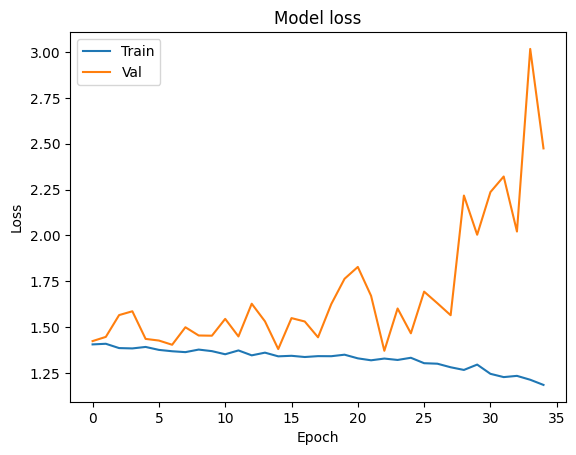

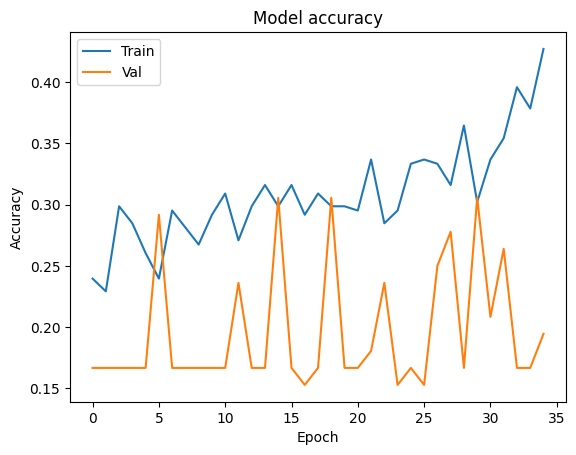

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [22]:
data_dir = "DATA_ORD_2"
slice_range = (58, 122)

data, labels = process_directory(data_dir, slice_range)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

test_data, test_labels = data, labels
batch_size = 2


test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(batch_size)

In [23]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

208/208 ━━━━━━━━━━━━━━━━━━━━ 31s 133ms/step - accuracy: 0.1324 - loss: 1.4341
Test Loss: 1.445674180984497
Test Accuracy: 0.09638553857803345


208/208 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step


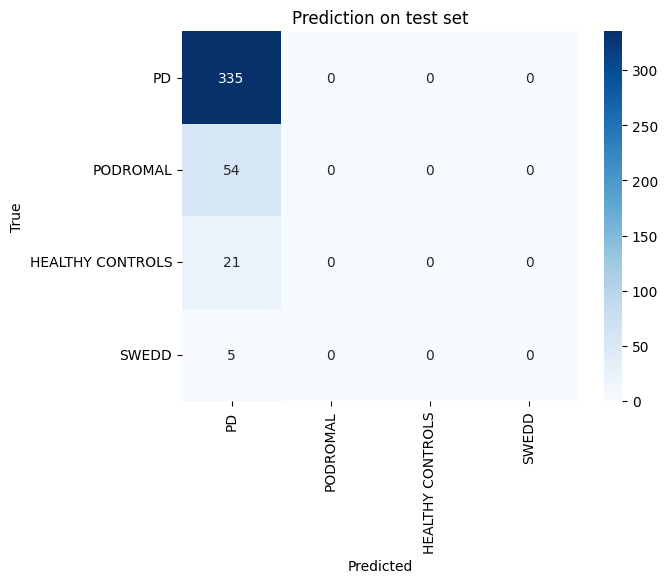


Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89       335
           1       0.00      0.00      0.00        54
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00         5

    accuracy                           0.81       415
   macro avg       0.20      0.25      0.22       415
weighted avg       0.65      0.81      0.72       415



c:\Users\andre\parkinson\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\parkinson\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\parkinson\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
predictions = model.predict(test_ds)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

test_labels = np.concatenate([y for x, y in test_ds], axis=0)
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(test_labels, predicted_labels)

class_names = ['PD', 'PODROMAL', 'HEALTHY CONTROLS', 'SWEDD']  # replace with actual class names
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Prediction on test set')
plt.show()

print("\nClassification Report:\n", classification_report(test_labels, predicted_labels))